In [1]:
import numpy as np
import pandas as pd
import numpy as np
import math
import random
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
from skimage import io, color, transform

# Part 1) Stretch Image

In [2]:
def partial_contrast_stretching(image, lower_threshold, upper_threshold):
    normalized_image = image / 255.0
    
    stretched_image = np.piecewise(normalized_image,
                                   [normalized_image < lower_threshold,
                                    (normalized_image >= lower_threshold) & (normalized_image <= upper_threshold),
                                    normalized_image > upper_threshold],
                                   [lambda x: 0,
                                    lambda x: ((x - lower_threshold) / (upper_threshold - lower_threshold))**2,
                                    lambda x: 1])

    # Scale the stretched image back to the original intensity range
    stretched_image = (stretched_image * 255).astype(np.uint8)

    return stretched_image

In [20]:
original_image = cv2.imread("example_img1.png", cv2.IMREAD_GRAYSCALE)

In [21]:
stretched_image = partial_contrast_stretching(original_image, lower_threshold=0.2, upper_threshold=0.8)

In [22]:
cv2.imshow('Original Image', original_image)
cv2.imshow('Stretched Image', stretched_image)
cv2.waitKey(5000)
cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x3e1d360) is not the object's thread (0x4f86fe0).
Cannot move to target thread (0x3e1d360)

QObject::moveToThread: Current thread (0x3e1d360) is not the object's thread (0x4f86fe0).
Cannot move to target thread (0x3e1d360)

QObject::moveToThread: Current thread (0x3e1d360) is not the object's thread (0x4f86fe0).
Cannot move to target thread (0x3e1d360)

QObject::moveToThread: Current thread (0x3e1d360) is not the object's thread (0x4f86fe0).
Cannot move to target thread (0x3e1d360)

QObject::moveToThread: Current thread (0x3e1d360) is not the object's thread (0x4f86fe0).
Cannot move to target thread (0x3e1d360)

QObject::moveToThread: Current thread (0x3e1d360) is not the object's thread (0x4f86fe0).
Cannot move to target thread (0x3e1d360)

QObject::moveToThread: Current thread (0x3e1d360) is not the object's thread (0x4f86fe0).
Cannot move to target thread (0x3e1d360)

QObject::moveToThread: Current thread (0x3e1d360) is not the object's thread

# 2) Initialize random initial clusters

In [23]:
def initialize_random_clusters(image, k):
    # Reshape the image to a 2D array of pixels
    pixels = image.reshape((-1, 1))

    # Randomly choose k initial cluster centers
    initial_centers = pixels[np.random.choice(pixels.shape[0], k, replace=False)]

    return initial_centers

In [25]:
original_image.shape, stretched_image.shape

((132, 179), (132, 179))

In [27]:
np.random.seed(1)
initial_clusters = initialize_random_clusters(stretched_image, 3)
initial_clusters

array([[255],
       [  5],
       [ 23]], dtype=uint8)

# Calculate potential of each pixel value

In [64]:
def progress(percent=0, width=50):
    left = width * percent // 100
    right = width - left

    tags = "#" * left
    spaces = " " * right
    percents = f"{percent:.0f}%"

    print("\r[", tags, spaces, "]", percents, sep="", end="", flush=True)

def potential_of_pixel(img, n, r_a = 0.5):
    x_n = img[n]
    x = img[:n]
    #print(f"x_n: {x_n}")
    #print(f"x: {x}")
    #print(f"x^2: {x**2}")
    
    P_n = np.sum((np.exp(-4*x_n - x**2))/(r_a**2))
    return P_n

def update_potentials(img, potential_index, potentials, r_b):
    x_p = img[potential_index]
    potential = potentials[potential_index]

    for n in range(potentials.shape[0]):
        x_n = img[n]
        potentials[n] -= (potential * (np.exp(-4*x_n - x_p**2))/(r_b**2))

    return potentials


def find_k_potential_centers(img, k, r_a, r_b):
    if k <= 0:
        return None
    assert type(k) == int
    potential_center_indices = []
    
    flatten_image = img.reshape(-1)
    #flatten_image = flatten_image / 255.0  # normalization
    potentials = np.zeros_like(flatten_image)
    for n in range(flatten_image.shape[0]):
        #perc = int(np.floor(n / (flatten_image.shape[0] / 100)))
        #if int(n % (flatten_image.shape[0]/100)) == 0:
        #    progress(perc)
        potential = potential_of_pixel(flatten_image, n, r_a=r_a)
        potentials[n] = potential
    initial_potential_center_index = np.where(potentials == potentials.max())[0][0]
    potential_center_indices.append(initial_potential_center_index)
    
    for i in range(1, k):
        id_last_potential = potential_center_indices[-1]
        potentials = update_potentials(flatten_image, id_last_potential, potentials, r_b=r_b)
        id_next_potential=np.where(potentials == potentials.max())[0][0]
        if id_next_potential not in potential_center_indices:
            potential_center_indices.append(id_next_potential)
        else:
            print(f"id: {id_next_potential} was alrdy selected, skipping")
            print(potentials[id_next_potential])
            print(flatten_image[id_next_potential])
            print(flatten_image[id_last_potential])
            
        
    return potential_center_indices
        
        
        

In [86]:
pot_centers = find_k_potential_centers(stretched_image, k=2, r_a=0.2, r_b=0.7)

/tmp/ipykernel_24305/2666268231.py:18: RuntimeWarning: overflow encountered in exp
  P_n = np.sum((np.exp(-4*x_n - x**2))/(r_a**2))
/tmp/ipykernel_24305/2666268231.py:46: RuntimeWarning: invalid value encountered in cast
  potentials[n] = potential


In [87]:
from sklearn.cluster import KMeans
def k_means_segmentation(image, k, initial_centers, tolerance=1e-4, max_iterations=100):
    rows, cols = image.shape
    image_flatten = image.flatten().reshape(-1, 1)

    kmeans = KMeans(n_clusters=k, init=initial_centers, n_init=1, max_iter=max_iterations, tol=tolerance)
    kmeans.fit(image_flatten)

    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    segmented_image = centers[labels].reshape(rows, cols)
    return segmented_image

In [88]:
k = 2
segmented_image = k_means_segmentation(stretched_image, k, np.array(pot_centers).reshape(-1,1))

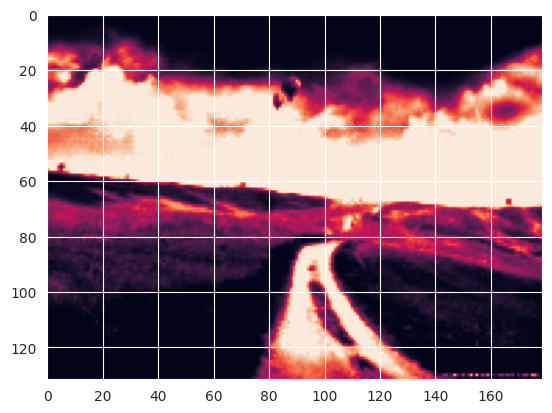

In [89]:
plt.imshow(stretched_image)